In [1]:
import random
import re
from typing import Literal, Optional, TypedDict

from IPython.display import Image
from langgraph.graph import END, START, StateGraph

In [2]:
class WorkflowState(TypedDict):
    """Represents the state of a workflow."""

    user_query: str
    location: Optional[str]
    weather_info: Optional[str]
    final_response: str


def simulate_weather_api(location: str) -> str:
    """
    Simulates calling a weather API for a given location.
    Returns a simple weather string.
    """
    temperature = random.randint(15, 25)
    condition = random.choice(["sunny", "cloudy", "partly cloudy"])
    return f"The weather in {location} is {condition} with a temperature of {temperature}°C."


def extract_location_and_get_weather(state: WorkflowState) -> WorkflowState:
    """
    Parses the user query to find a location, simulates fetching weather,
    and updates the state.
    """
    query = state["user_query"]
    location = None
    weather_info = None

    match = re.search(r"weather in (\w+)", query, re.IGNORECASE)
    if match:
        location = match.group(1).strip()
        weather_info = simulate_weather_api(location)
    else:
        weather_info = "Sorry, I couldn't identify a location in your request."

    # Only return fields that are updated by this node
    return {
        "location": location,
        "weather_info": weather_info,
    }


def format_weather_response(state: WorkflowState) -> WorkflowState:
    """Formats a response including the fetched weather information."""
    weather_info = state["weather_info"]
    final_response = f"Here’s the latest weather information. {weather_info}"
    return {"final_response": final_response}


def format_failed_response(state: WorkflowState) -> WorkflowState:
    """Formats a response indicating the weather check could not be completed."""
    weather_info = state["weather_info"]  # Contains the reason for failure
    final_response = f"I couldn't get the weather information. {weather_info}"
    return {"final_response": final_response}


def route_after_weather_check(
    state: WorkflowState,
) -> Literal["format_weather_response", "format_failed_response"]:
    """
    Decides the next step based on whether weather information was successfully retrieved.
    """
    if (
        state["location"] and "Sorry" not in state["weather_info"]
    ):  # Check if location was found and API didn't return an error message
        return "format_weather_response"
    else:
        return "format_failed_response"

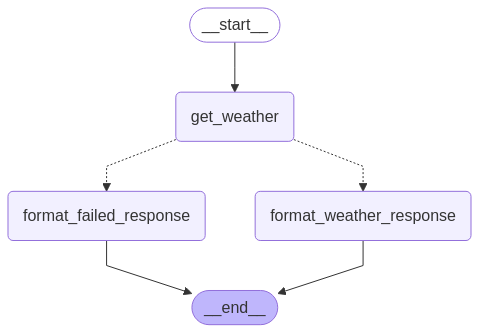

In [3]:
builder = StateGraph(WorkflowState)

builder.add_node("get_weather", extract_location_and_get_weather)
builder.add_node("format_weather_response", format_weather_response)
builder.add_node("format_failed_response", format_failed_response)

builder.add_edge(START, "get_weather")
builder.add_conditional_edges(
    "get_weather",
    route_after_weather_check,
    {  # Map the return values of route_after_weather_check to node names
        "format_weather_response": "format_weather_response",
        "format_failed_response": "format_failed_response",
    },
)
builder.add_edge("format_weather_response", END)
builder.add_edge("format_failed_response", END)


graph = builder.compile()

Image(graph.get_graph().draw_mermaid_png())

In [4]:
inputs = {"user_query": "What is the weather in Berlin today?"}
final_state = graph.invoke(inputs)
final_state

{'user_query': 'What is the weather in Berlin today?',
 'location': 'Berlin',
 'weather_info': 'The weather in Berlin is sunny with a temperature of 22°C.',
 'final_response': 'Here’s the latest weather information. The weather in Berlin is sunny with a temperature of 22°C.'}

In [5]:
inputs = {"user_query": "Hello, how are you?"}
final_state = graph.invoke(inputs)
final_state

{'user_query': 'Hello, how are you?',
 'location': None,
 'weather_info': "Sorry, I couldn't identify a location in your request.",
 'final_response': "I couldn't get the weather information. Sorry, I couldn't identify a location in your request."}